# Sentiment-Augmented Forecasting

Use the combined modeling dataset to compare baseline PP models vs sentiment-augmented models. We run rolling-origin tests, compute metrics, and inspect coefficients to quantify the incremental value of OPEC sentiment.

In [1]:
from pathlib import Path
import sys
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

NOTEBOOK_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
ROOT = NOTEBOOK_DIR.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.model_dataset_utils import build_modeling_dataset
from src.sentiment_model_utils import (
    define_model_specs,
    run_models_backtest,
    compute_forecast_metrics,
    extract_coefficients,
    plot_forecast_vs_actual,
    plot_forecast_errors,
    plot_coefficients,
)

DATA = ROOT / "data"
ART = ROOT / "artifacts"
PLOTS = ROOT / "plots"
for path in (ART, PLOTS):
    path.mkdir(parents=True, exist_ok=True)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
print(f"ROOT set to {ROOT}")


ROOT set to c:\PythonProjects\LLM-polypropylene


In [2]:
df_model = pd.DataFrame()

artifact_path = ART / "modeling_dataset_monthly.csv"
if artifact_path.exists():
    df_model = pd.read_csv(artifact_path, parse_dates=["date"])
    df_model = df_model.set_index("date").sort_index()
    print(f"Loaded modeling dataset from {artifact_path}")
else:
    print("Modeling dataset artifact missing; rebuilding in memory via build_modeling_dataset().")
    df_model, _ = build_modeling_dataset(ROOT)

if df_model.empty:
    print("Modeling dataset is empty; please run notebooks 02, 06, 07 first.")
else:
    print(f"Shape: {df_model.shape}")
    print(f"Date range: {df_model.index.min().date()} to {df_model.index.max().date()}")
    print(f"Columns: {list(df_model.columns)}")
    display(df_model.head())
    display(df_model.tail())


Loaded modeling dataset from c:\PythonProjects\LLM-polypropylene\artifacts\modeling_dataset_monthly.csv
Shape: (130, 16)
Date range: 2015-02-28 to 2025-11-30
Columns: ['PP', 'PGP', 'CRUDE', 'ret_PP', 'ret_PGP', 'ret_CRUDE', 'resid_PP', 'score_demand', 'score_overall', 'score_price_outlook', 'score_supply', 'index_demand', 'index_overall', 'index_price_outlook', 'index_supply', 'index_hybrid']


,PP,PGP,CRUDE,ret_PP,ret_PGP,ret_CRUDE,resid_PP,score_demand,score_overall,score_price_outlook,score_supply,index_demand,index_overall,index_price_outlook,index_supply,index_hybrid
date,,,,,,,,,,,,,,,,
2015-02-28,8748.0,8748.0,50.724736,0.054348,0.054348,0.069364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,8829.4,8829.4,47.854091,0.009262,0.009262,-0.058257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,9348.0,9348.0,54.628096,0.057075,0.057075,0.132392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,9142.0,9142.0,59.372000,-0.022283,-0.022283,0.083274,-0.025787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,8786.0,8786.0,59.828637,-0.039720,-0.039720,0.007662,-0.033245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,PP,PGP,CRUDE,ret_PP,ret_PGP,ret_CRUDE,resid_PP,score_demand,score_overall,score_price_outlook,score_supply,index_demand,index_overall,index_price_outlook,index_supply,index_hybrid
date,,,,,,,,,,,,,,,,
2025-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.465910,0.7,0.730664,-0.382759,-13.950573,8.3,33.377305,5.704018,8.357687
2025-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.439590,0.7,0.341918,-0.376988,-14.390164,9.0,33.719222,5.327030,8.414022
2025-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.592581,0.3,0.675067,-0.389453,-14.982745,9.3,34.394289,4.937577,8.412280
2025-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.494205,0.4,0.173203,-0.468063,-15.476949,9.7,34.567492,4.469514,8.315014
2025-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.406237,0.3,-0.027499,-0.509039,-15.883186,10.0,34.539993,3.960475,8.154320


In [3]:
if df_model.empty:
    print("No data to define model specs.")
else:
    specs = define_model_specs(df_model)
    if not specs:
        print("No model specs could be defined (missing necessary columns).")
    else:
        for s in specs:
            print(f"Model {s.name}: target={s.target}, regressors={s.regressors}, target_lags={s.target_lags}, reg_lags={s.reg_lags}")


Model A_baseline: target=resid_PP, regressors=['ret_CRUDE', 'ret_PGP'], target_lags=[1], reg_lags={'ret_CRUDE': [1], 'ret_PGP': [1]}
Model B_sentiment_hybrid: target=resid_PP, regressors=['ret_CRUDE', 'ret_PGP', 'index_hybrid'], target_lags=[1], reg_lags={'ret_CRUDE': [1], 'ret_PGP': [1], 'index_hybrid': [0, 1]}
Model C_sentiment_sections: target=resid_PP, regressors=['ret_CRUDE', 'ret_PGP', 'index_hybrid', 'index_demand', 'index_supply', 'index_price_outlook'], target_lags=[1], reg_lags={'ret_CRUDE': [1], 'ret_PGP': [1], 'index_hybrid': [0, 1], 'index_demand': [0, 1], 'index_supply': [0, 1], 'index_price_outlook': [0, 1]}


In [4]:
backtest_df = pd.DataFrame()

if df_model.empty:
    print("Skipping backtest; dataset is empty.")
elif not specs:
    print("Skipping backtest; no model specs.")
else:
    TEST_MONTHS = 24
    MIN_TRAIN = 36
    backtest_df = run_models_backtest(df_model, specs, test_size_months=TEST_MONTHS, min_train_months=MIN_TRAIN)
    if backtest_df.empty:
        print("Backtest produced no results; check data length or specs.")
    else:
        print(f"Backtest rows: {len(backtest_df)}, models: {backtest_df['model_name'].nunique()}")
        display(backtest_df.head())
        out_path = ART / "sentiment_backtest_results.csv"
        backtest_df.to_csv(out_path, index=False)
        print(f"Saved backtest results -> {out_path}")


Backtest rows: 72, models: 3


,date,y_true,y_pred,model_name,train_end
0,2023-04-30,-0.014802,-0.005182,A_baseline,2023-03-31
1,2023-05-31,-0.053684,-0.002118,A_baseline,2023-04-30
2,2023-06-30,0.000785,-0.013949,A_baseline,2023-05-31
3,2023-07-31,0.016094,-0.000106,A_baseline,2023-06-30
4,2023-08-31,0.049295,0.005123,A_baseline,2023-07-31


Saved backtest results -> c:\PythonProjects\LLM-polypropylene\artifacts\sentiment_backtest_results.csv


In [5]:
metrics_df = pd.DataFrame()
if backtest_df.empty:
    print("Skipping metrics; no backtest results.")
else:
    metrics_df = compute_forecast_metrics(backtest_df)
    display(metrics_df)
    metrics_path = ART / "sentiment_model_metrics.csv"
    metrics_df.to_csv(metrics_path, index=False)
    print(f"Saved metrics -> {metrics_path}")


,model_name,N,MAE,RMSE,MAPE,Directional_Accuracy
0,A_baseline,24,0.015783,0.020950,0.735172,0.458333
1,B_sentiment_hybrid,24,0.018708,0.022892,0.558053,0.375000
2,C_sentiment_sections,24,0.029359,0.034768,-0.083298,0.375000


Saved metrics -> c:\PythonProjects\LLM-polypropylene\artifacts\sentiment_model_metrics.csv


In [6]:
coefs_df = pd.DataFrame()
if df_model.empty or not specs:
    print("Skipping coefficient extraction; missing data/specs.")
else:
    coefs_df = extract_coefficients(df_model, specs)
    display(coefs_df.head())
    coefs_path = ART / "sentiment_model_coefficients.csv"
    coefs_df.to_csv(coefs_path, index=False)
    print(f"Saved coefficients -> {coefs_path}")


,model_name,variable,coefficient
0,A_baseline,resid_PP_lag1,-0.227014
1,A_baseline,ret_CRUDE_lag1,-0.029404
2,A_baseline,ret_PGP_lag1,0.454791
3,A_baseline,intercept,0.001219
4,B_sentiment_hybrid,resid_PP_lag1,0.269924


Saved coefficients -> c:\PythonProjects\LLM-polypropylene\artifacts\sentiment_model_coefficients.csv


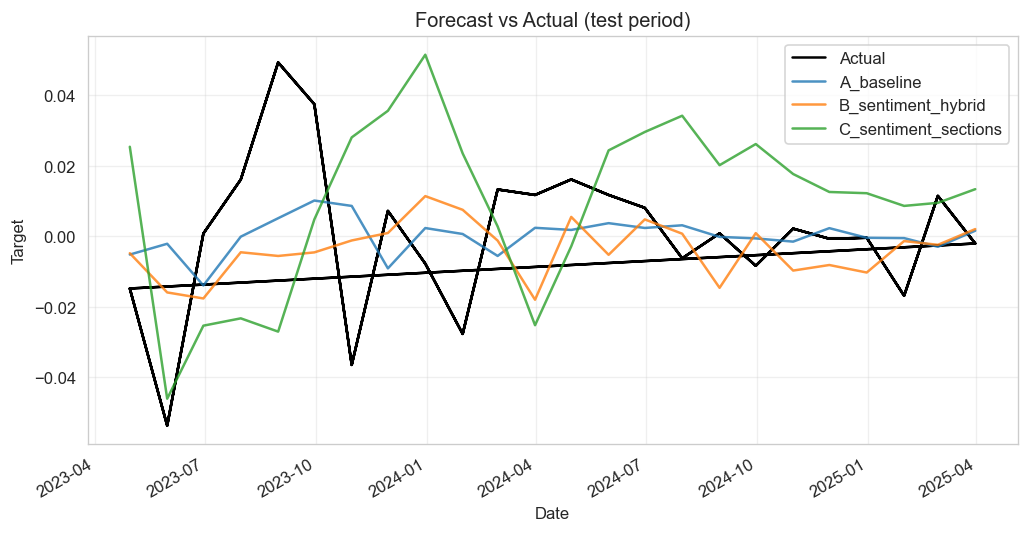

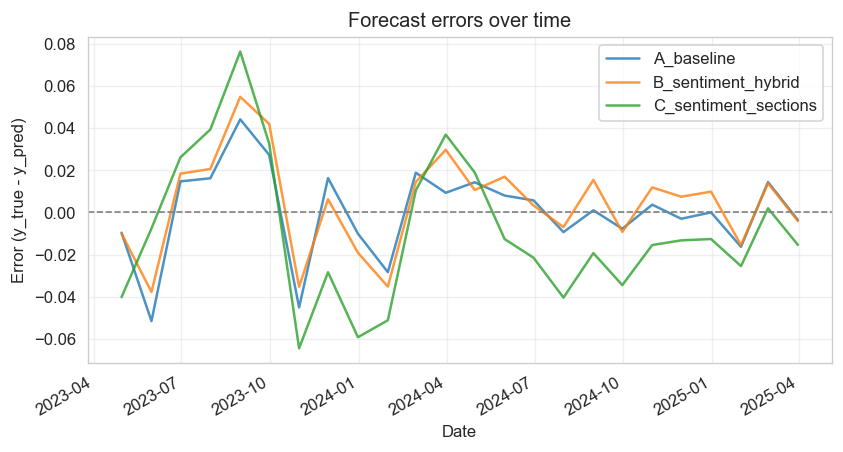

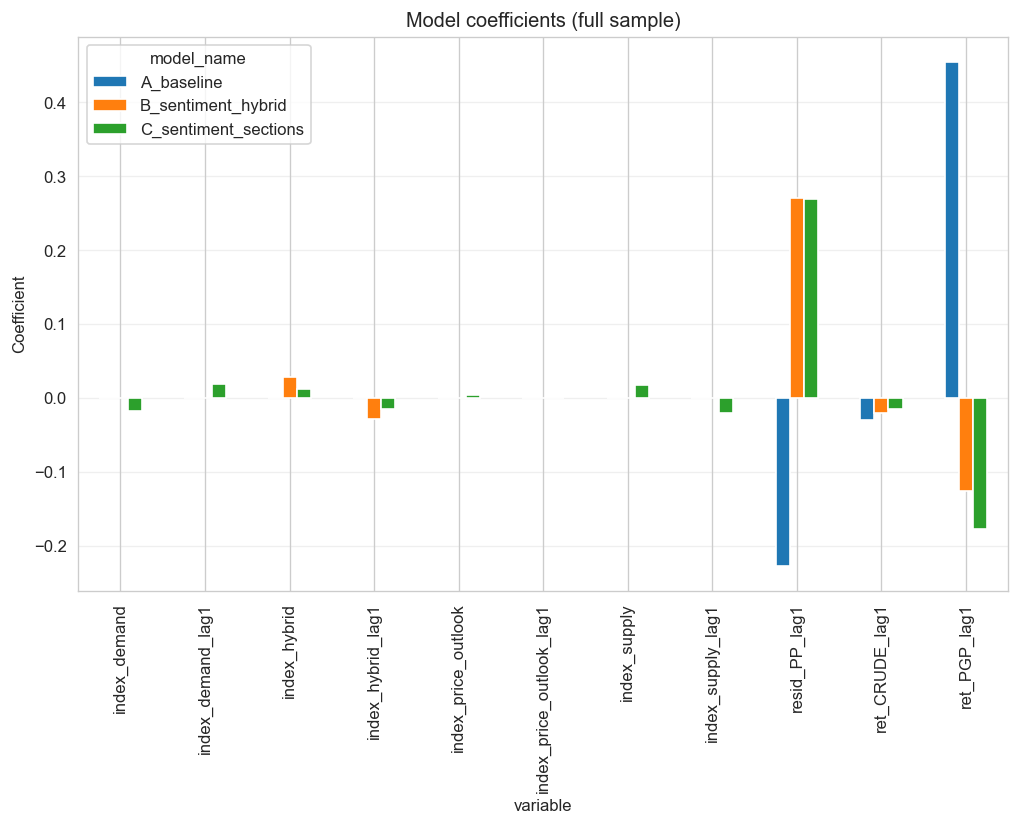

In [7]:
if backtest_df.empty:
    print("Skipping plots; no backtest results.")
else:
    try:
        fig1 = plot_forecast_vs_actual(backtest_df)
        path1 = PLOTS / "forecast_vs_actual_baseline_vs_sentiment.png"
        fig1.savefig(path1, dpi=150, bbox_inches="tight")
        display(fig1)
    except Exception as exc:
        print(f"Forecast vs actual plot failed: {exc}")
    finally:
        plt.close('all')

    try:
        fig2 = plot_forecast_errors(backtest_df)
        path2 = PLOTS / "forecast_errors_baseline_vs_sentiment.png"
        fig2.savefig(path2, dpi=150, bbox_inches="tight")
        display(fig2)
    except Exception as exc:
        print(f"Forecast errors plot failed: {exc}")
    finally:
        plt.close('all')

    if not coefs_df.empty:
        try:
            fig3 = plot_coefficients(coefs_df)
            path3 = PLOTS / "sentiment_model_coefficients.png"
            fig3.savefig(path3, dpi=150, bbox_inches="tight")
            display(fig3)
        except Exception as exc:
            print(f"Coefficient plot failed: {exc}")
        finally:
            plt.close('all')


In [8]:
if metrics_df is None or metrics_df.empty:
    print("No metrics to interpret.")
else:
    best = metrics_df.sort_values('RMSE').iloc[0]
    print(f"Best model by RMSE: {best['model_name']} (RMSE={best['RMSE']:.4f}, MAE={best['MAE']:.4f})")
    if 'A_baseline' in metrics_df['model_name'].values:
        base_rmse = metrics_df.loc[metrics_df['model_name']=='A_baseline', 'RMSE'].iloc[0]
        if base_rmse > 0:
            improvement = (base_rmse - best['RMSE']) / base_rmse
            print(f"Improvement vs baseline: {improvement*100:.1f}%")
    print("Use these results to discuss whether sentiment adds forecasting value.")


Best model by RMSE: A_baseline (RMSE=0.0209, MAE=0.0158)
Improvement vs baseline: 0.0%
Use these results to discuss whether sentiment adds forecasting value.
